# Kernel regression

**What you will learn today**: You will learn how to implement kernel regression. First we analyze a synthetic dataset: you will build the feature map associated with different kernels and we see how the learning performance can be different. As always after having understood the theoretical insights we step on to real-dataset problem: you can play using our dear friend sklearn to implement Kernel Ridge Regression, with a kernel of your choice.


# 1) KRR from scratch 

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Remember first lecture?  Let us use pandas for handling synthetic dataset

In [11]:
data = pd.read_csv('dataTP8.csv')

In [12]:
x,y = np.array(data['X']), np.array(data['Y'])

Let's see how it looks like

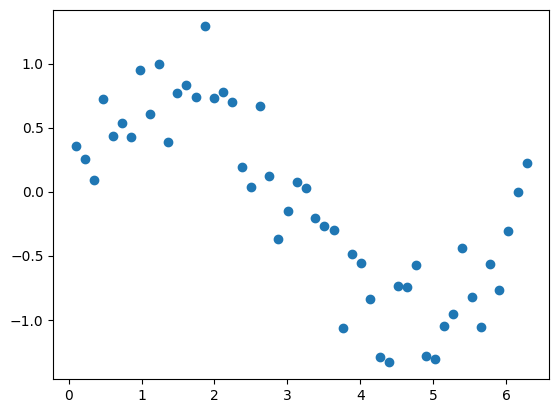

In [13]:
plt.plot(x,y,'o') 

It does not seem a bad idea to use a polynomial fitting here. We have introduced in the theoretical lectures kernel methods: $$K(x,y) = {\phi(x)}^T{\phi(y)}$$

Let us pick for the first part of the analysis a feature map of the form:
$$ \phi_k^{(p)}(x) = x^k  \,\,\,\,\,\,\,\, k=1 \dots p $$

You may have studied this under the name *linear basis regression*.

The tools we need once we have mapped the datapoints in feature space are the usual one of linear regression as we know and all will be straight-forward.
We will study the behaviour as the degree $p$ varies, this will vary the complexity of the fitting model leading us to our usual bias-variance tradeoff consideration.

In [14]:
def build_poly(x, degree,choice='none',gamma=1):
    """polynomial basis functions for input data x, for j=0 up to j=degree."""
    x_pol = []
    
    for i in range(0,len(x)):
        x_pol_ele = []
        if choice == "rbf":
          x_pol_ele = np.exp(-x[i]*x[i]/gamma)*np.array([x[i]**j/(np.math.factorial(j)*np.sqrt(gamma**j)) for j in range(0,degree+1)])
        else:
          x_pol_ele = np.array([x[i]**j for j in range(0,degree+1)])
        x_pol.append(x_pol_ele)
    return np.array(x_pol)

def ridge_regression(y, X, lambda_):
    """implement ridge regression."""
    Xt = np.transpose(X)
    I = np.eye(len(Xt))
    w =  np.linalg.solve(Xt@X + (2*lambda_*len(y))*I,Xt@y)
    mse = (1/(2*len(y)))*np.sum((y-np.matmul(X,w))**2)
    return mse,w

def polynomial_regression(x,y,degrees,lambda_, choice='none'):
    num = len(degrees)
    fig, axs = plt.subplots(num,figsize=(15,15)) ; i =-1
    for degree in (degrees):
        i+=1   ; phi = build_poly(x, degree, choice=choice)
        
        mse , weights = ridge_regression(y, phi,lambda_)
        rmse = np.sqrt(2*mse)

        print("Processing {j}th experiment, degree={d}, rmse={loss}".format(
              j=i + 1, d=degree, loss=rmse))
        # print(weights)
        # plot fit
        # fhat = np.dot(phi,weights)
        xvals = np.arange(min(x) - 0.1, max(x) + 0.1, 0.1)
        phi = build_poly(xvals, degree, choice=choice) ; fhat = np.dot(phi,weights)
        axs[i].plot(x,
            y, 'o',label=f'Degree={degree} -- Data')
        axs[i].plot(xvals,
            fhat,label=f'Fit')
        axs[i].set_ylim([-1.4,1.4])
        axs[i].legend()
    # plt.tight_layout()
    

Processing 1th experiment, degree=5, rmse=0.2545435645040046
Processing 2th experiment, degree=12, rmse=0.24434768553812422
Processing 3th experiment, degree=20, rmse=0.24303972823266862
Processing 4th experiment, degree=50, rmse=0.22556911596168988
Processing 5th experiment, degree=80, rmse=0.2133332583334366
Processing 6th experiment, degree=120, rmse=0.21030210140135566
Processing 7th experiment, degree=160, rmse=0.21385555499980236


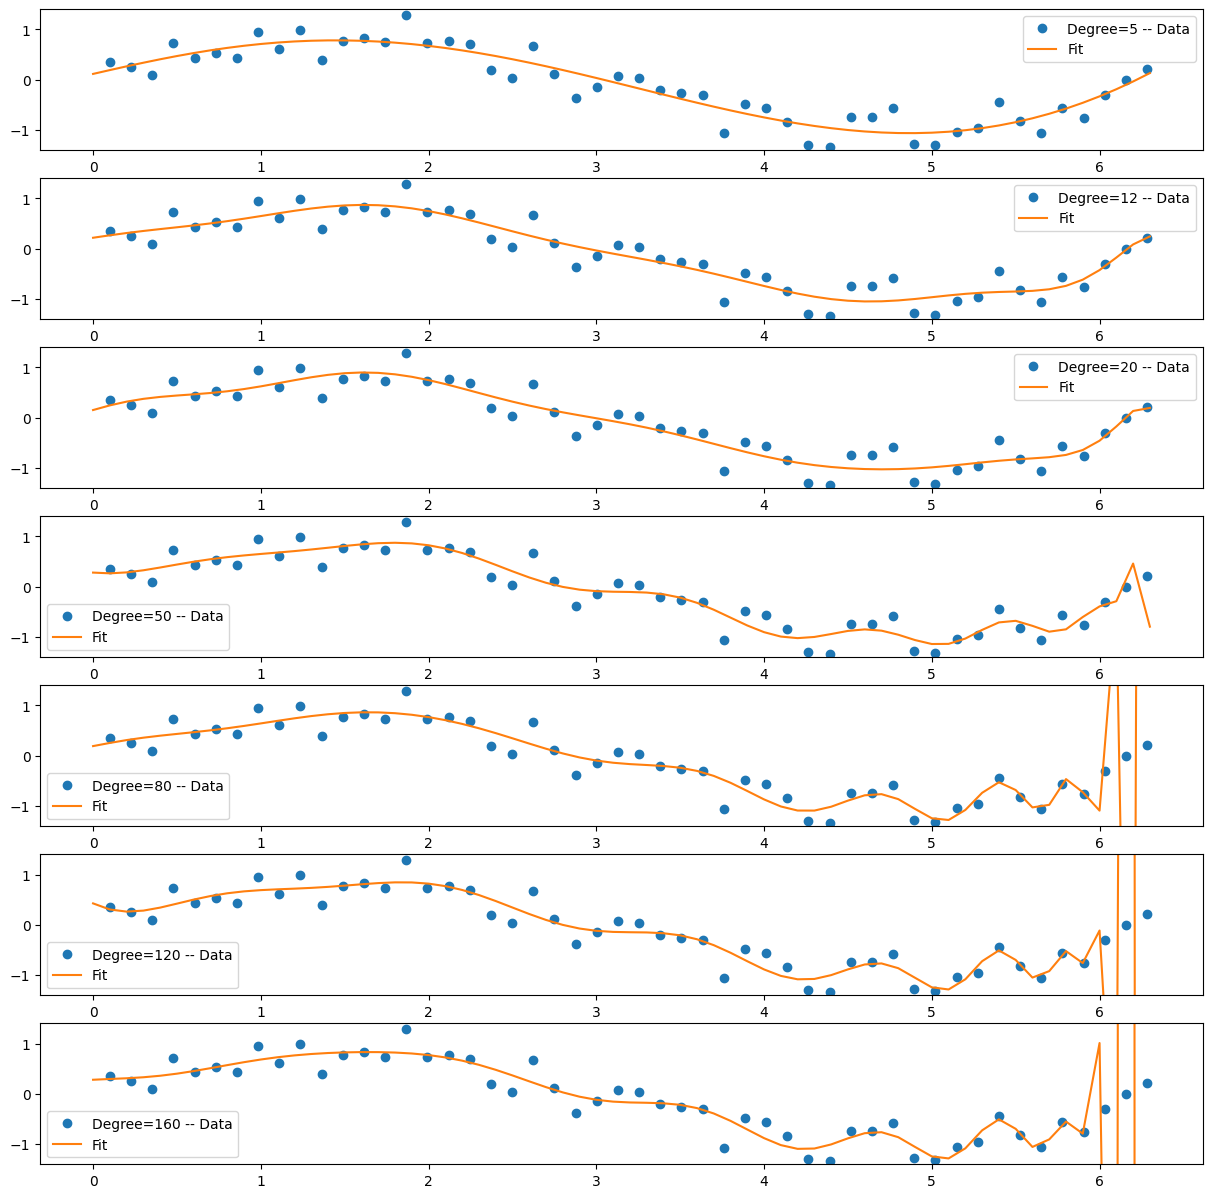

In [15]:
degrees = [5,12,20,50,80,120,160] ; lambda_ = 10e-6
polynomial_regression(x,y,degrees,lambda_)

We clearly see that by choosing a value of the degree too high we start to have bad fitting (i.e. overfitting). This feature map is not building a good kernel for studying the data.

It is interesting to understand if we can build another feature map, always in a polynomial fashion, that is able to having good learning rates.

First let's introduce some functions to split data in training and testing dataset to evaluate the performance of the model.

In [16]:
def split_data(x, y, ratio, seed=1):
    # set seed
    np.random.seed(seed)
    # ***************************************************
    index = np.arange(0,len(x))
    index_train = np.random.choice(index, int(ratio*len(x)), replace=False)
    
    training_x = x[index_train]
    training_y = y[index_train]
    test_x = x[[i for i in range(len(x)) if i not in index_train]]
    test_y = y[[i for i in range(len(y)) if i not in index_train]]
    
    return training_x, training_y, test_x, test_y

## Exercise
* Implement kernel regression with the feature map parametrized by $\gamma$ which we encode with the codework *rbf*: 

$$ \phi_k^{(p)}(x) = e^{\frac{-x^2}{\gamma}}\frac{x^k}{k!}  \,\,\,\,\,\,\,\, k=1 \dots p $$
* Fixing a high degree, for example 100, study the behaviour as a function of $\lambda$ and $\gamma$ of the learning curves (test error and training error) and compare with what you would see with the previous feature map.
* What do you conclude?



In [17]:
#YOUR TURN
x_train, y_train, x_test, y_test = split_data(x, y, 0.8)

/var/folders/jf/sxgjcs2s1p3_ltpz295jggpm0000gn/T/ipykernel_2202/139828896.py:8: RuntimeWarning: divide by zero encountered in double_scalars
  x_pol_ele = np.exp(-x[i]*x[i]/gamma)*np.array([x[i]**j/(np.math.factorial(j)*np.sqrt(gamma**j)) for j in range(0,degree+1)])
/var/folders/jf/sxgjcs2s1p3_ltpz295jggpm0000gn/T/ipykernel_2202/139828896.py:8: RuntimeWarning: invalid value encountered in multiply
  x_pol_ele = np.exp(-x[i]*x[i]/gamma)*np.array([x[i]**j/(np.math.factorial(j)*np.sqrt(gamma**j)) for j in range(0,degree+1)])


The best test rmse is 0.26 for lambda=1.00e-07 and gamma=12.74


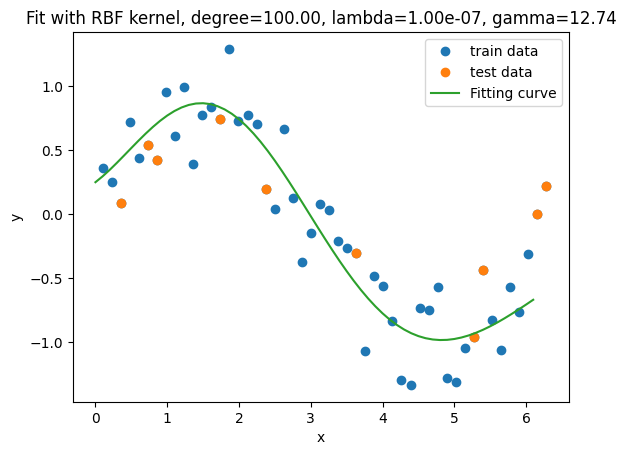

In [18]:
from cProfile import label


degree = 100

Grid_lambda = np.logspace(-7, 1, 20)
Grid_gamma = np.logspace(-6, 3, 20)

# Grid search
best_rmse = np.inf
best_gamma = None
best_lambda = None
best_weights = None
for Lambda in Grid_lambda:
    for gamma in Grid_gamma:
        phi = build_poly(x_train, degree, choice='rbf',gamma=gamma)
        mse , weights = ridge_regression(y_train, phi,Lambda)
        rmse = np.sqrt(2*mse)
        if rmse < best_rmse:
            best_rmse = rmse
            best_gamma = gamma
            best_lambda = Lambda
            best_weights = weights
print(f'The best test rmse is {best_rmse:.2f} for lambda={best_lambda:.2e} and gamma={best_gamma:.2f}')

plt.title(f'Fit with RBF kernel, degree={degree:.2f}, lambda={best_lambda:.2e}, gamma={best_gamma:.2f}')
plt.xlabel('x')
plt.ylabel('y')
plt.plot(x,y,'o', label='train data')
plt.plot(x_test,y_test,'o', label='test data')
xvals = np.arange(min(x_train) - 0.1, max(x_train) + 0.1, 0.1)
phi = build_poly(xvals, degree, choice='rbf', gamma=best_gamma)
fhat = np.dot(phi,best_weights)
plt.plot(xvals,fhat,label='Fitting curve')
plt.legend()
plt.show()

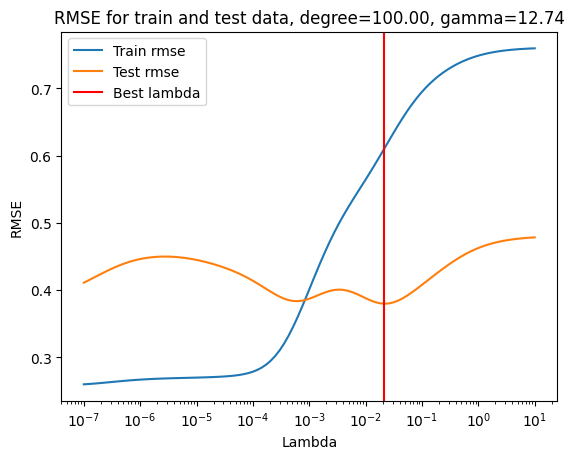

The best lambda is 2.15e-02


In [19]:
rmse_test = []
rmse_train = []
Grid_lambda = np.logspace(-7, 1, 100)
for Lambda in Grid_lambda:
    phi = build_poly(x_train, degree, choice='rbf',gamma=best_gamma)
    mse , weights = ridge_regression(y_train, phi,Lambda)
    rmse = np.sqrt(2*mse)
    rmse_train.append(rmse)
    phi_test = build_poly(x_test, degree, choice='rbf',gamma=best_gamma)
    mse_test = np.sqrt(2*(1/(2*len(y_test)))*np.sum((y_test-np.matmul(phi_test,weights))**2))
    rmse_test.append(mse_test)
plt.plot(Grid_lambda,rmse_train,label='Train rmse')
plt.plot(Grid_lambda,rmse_test,label='Test rmse')
plt.semilogx()
plt.title(f'RMSE for train and test data, degree={degree:.2f}, gamma={best_gamma:.2f}')
plt.axvline(x=Grid_lambda[np.argmin(rmse_test)],color='r',label='Best lambda')
plt.xlabel('Lambda')
plt.ylabel('RMSE')
plt.legend()
plt.show()
print(f'The best lambda is {Grid_lambda[np.argmin(rmse_test)]:.2e}')

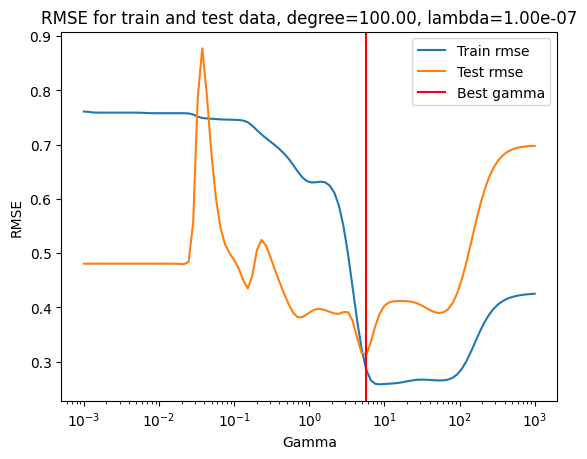

In [20]:
rmse_test = []
rmse_train = []
Lambda = best_lambda
Grid_gamma = np.logspace(-3, 3, 100)
for gamma in Grid_gamma:
    phi = build_poly(x_train, degree, choice='rbf',gamma=gamma)
    mse , weights = ridge_regression(y_train, phi,Lambda)
    rmse = np.sqrt(2*mse)
    rmse_train.append(rmse)
    phi_test = build_poly(x_test, degree, choice='rbf',gamma=gamma)
    mse_test = np.sqrt(2*(1/(2*len(y_test)))*np.sum((y_test-np.matmul(phi_test,weights))**2))
    rmse_test.append(mse_test)

plt.plot(Grid_gamma,rmse_train,label='Train rmse')
plt.plot(Grid_gamma,rmse_test,label='Test rmse')
plt.axvline(x=Grid_gamma[np.argmin(rmse_test)],color='r',label='Best gamma')
plt.title(f'RMSE for train and test data, degree={degree:.2f}, lambda={best_lambda:.2e}')
plt.xlabel('Gamma')
plt.ylabel('RMSE')
plt.semilogx()
plt.legend()
plt.show()

# 2) Kernel methods using Sklearn 

We have seen how to build Kernel Ridge Regression (KRR) from scratch starting from the feature map. The idea to map datapoint in an higher dimensional space (i.e. kernel trick) can be used also in classification task. We will consider again our old friend MNIST, we will consider SVC (Support Vector Classification). We will see that, at stake with previous lecture, *SVC* will accept the parameter *kernel* to choose in which space mapping our datapoints.

In [21]:
import time

from sklearn.datasets import fetch_openml # MNIST data
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import check_random_state

print(__doc__)

# Turn down for faster convergence
t0 = time.time()
train_size = 9000 # 60000
test_size = 1500 # 10000

### load MNIST data from https://www.openml.org/d/554
X, y = fetch_openml('mnist_784', return_X_y=True, as_frame=False)
X = np.array(X)[:train_size+test_size]
y = np.array(y)[:train_size+test_size]

Automatically created module for IPython interactive environment


/Users/vincentroduit/.pyenv/versions/3.9.13/envs/scientific/lib/python3.9/site-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


Let's plot an image to see how it looks like with plt.imshow.

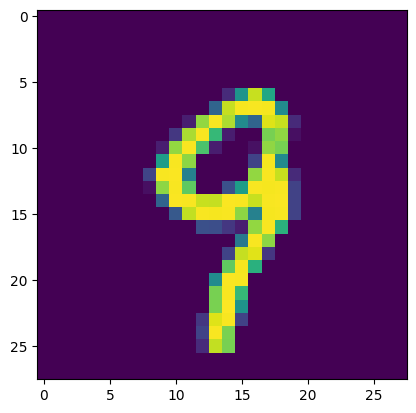

In [22]:
plt.imshow(X[6542,:].reshape(28,28))

We shuffle the data and we do the test-train splitting.

In [23]:
# shuffle data
random_state = check_random_state(0)
permutation = random_state.permutation(X.shape[0])
X = X[permutation]
y = y[permutation]
X = X.reshape((X.shape[0], -1))
# pick training and test data sets 
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=train_size,test_size=test_size)

We preproccess the data and use StandardScaler to have zero mean and unit variance. Pay attention that we do that only on the training set!

In [24]:
# scale data to have zero mean and unit variance [required by regressor]
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Exercise
- Repeat what you did in the previous lecture for a "linear" SVM classifier with the *rbf* kernel.
- Go and search the Python doc for SVM classifier to see how to implement it. 
- Optimize the regularization parameter using CV. Use default value for the parameter which characterize the kernel (e.g. variance in the gaussian kernel) and change *C* between $10^{-5}$ and $10^5$.
- How is the $\gamma$ hyperparameter fixed by default in the *rbf* implemented in sklearn? Try to play with the choice of $\gamma$ and see (qualitatively) what happens.

In [25]:
# YOUR TURN

According to sklearn, the hyperparameter $\gamma$ is set by default to $\frac{1}{n_{features} * X.var()}$

In [26]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'C': np.logspace(-5, 5, 5)}
]

cv_svc = GridSearchCV(SVC(tol=0.1, kernel='rbf'), param_grid, cv=2, scoring='accuracy', n_jobs=-1)
cv_svc.fit(X_train, y_train)

print(f'Best C value: {cv_svc.best_params_["C"]}')
print(f'Best accuracy: {cv_svc.best_score_*100:.2f}%')

Best C value: 316.22776601683796
Best accuracy: 93.14%


In [27]:
y_predict = cv_svc.predict(X_test)
accuracy = np.mean(y_predict == y_test) * 100
print(f'The accuracy on test set is {accuracy:.2f}%')

The accuracy on test set is 94.40%


Computing for gamma=0.00...
Computing for gamma=0.00...
Computing for gamma=0.03...
Computing for gamma=1.78...
Computing for gamma=100.00...


Text(0, 0.5, 'Accuracy')

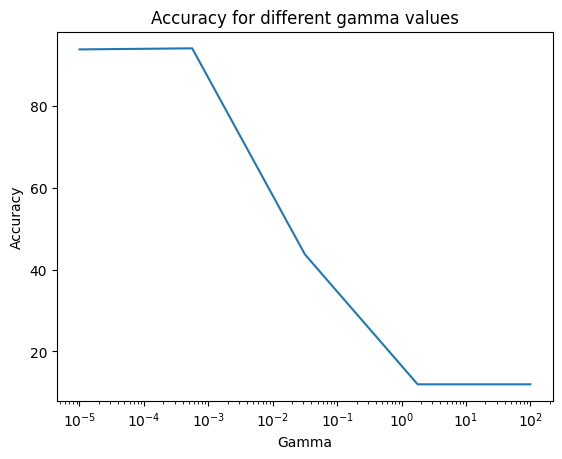

In [28]:
gamma_tab = np.logspace(-5, 2, 5)
accuracy_tab = []
for gamma in gamma_tab:
    print(f'Computing for gamma={gamma:.2f}...')
    svc = SVC(C=cv_svc.best_params_["C"],tol=0.1, kernel='rbf', gamma=gamma)
    svc.fit(X_train, y_train)
    y_predict = svc.predict(X_test)
    accuracy = np.mean(y_predict == y_test) * 100
    accuracy_tab.append(accuracy)

plt.plot(gamma_tab,accuracy_tab)
plt.semilogx()
plt.title('Accuracy for different gamma values')
plt.xlabel('Gamma')
plt.ylabel('Accuracy')

From this graph one can see that the accuracy decreases when gamma is increasing.